## 权重衰减
前⼀节描述了过拟合的问题，本节将介绍⼀些正则化模型的技术。
可以通过调整拟合多项式的阶数来限制模型的容量。实际上，限制特征的数量是缓解过拟合的⼀种常⽤技术。然⽽，简单地丢弃特征对这项⼯作来说可能过于⽣硬。
我们继续思考多项式回归的例⼦，考虑⾼维输⼊可能发⽣的情况。多项式对多变量数据的⾃然扩展称为单项式（monomials），也可以说是变量幂的乘积。

在训练参数化机器学习模型时，权重衰减（weight decay）是最⼴泛使⽤的正则化的技术之⼀，它通常也被称为L2正则化。这项技术通过函数与零的距离来衡量函数的复杂度，因为在所有函数f中，函数f = 0（所有输⼊都得到值0）在某种意义上是最简单的。  
种简单的⽅法是通过线性函数 f(x) = w⊤x 中的权重向量的某个范数来度量其复杂性，例如∥w∥^2。要保证权重向量⽐较⼩，最常⽤⽅法是将其范数作为惩罚项加到最⼩化损失的问题中。将原来的训练⽬标最⼩化训练标签上的预测损失，调整为最⼩化预测损失和惩罚项之和。现在，如果我们的权重向量增⻓的太⼤，我们的学习算法可能会更集中于最⼩化权重范数∥w∥^2。  
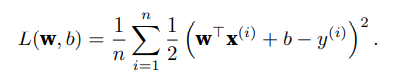  

x(i)是样本i的特征，y(i)是样本i的标签，(w, b)是权重和偏置参数。为了惩罚权重向量的⼤⼩，我们必须以某种⽅式在损失函数中添加∥w∥^2，但是模型应该如何平衡这个新的额外惩罚的损失？实际上，我们通过正则化常数λ来描述这种权衡，这是⼀个⾮负超参数，我们使⽤验证数据拟合：  
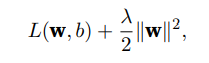  

【说明】：
* 对于λ = 0，我们恢复了原来的损失函数。对于λ > 0，我们限制∥w∥的⼤⼩。这⾥我们仍然除以2：当我们取⼀个⼆次函数的导数时，2和1/2会抵消，以确保更新表达式看起来既漂亮⼜简单。
* 为什么在这⾥我们使⽤平⽅范数⽽不是标准范数（即欧⼏⾥得距离）？我们这样做是为了便于计算。通过平⽅L2范数，我们去掉平⽅根，留下权重向量每个分量的平⽅和。这使得惩罚的导数很容易计算：导数的和等于和的导数。
* ⾸先使⽤L2范数，⽽不是L1范数。事实上，这个选择在整个统计领域中都是有效的和受欢迎的。L2正则化线性模型构成经典的岭回归（ridge regression）算法，L1正则化线性回归是统计学中类似的基本模型，通常被称为套索回归（lasso regression）。使⽤L2范数的⼀个原因是它对权重向量的⼤分量施加了巨⼤的惩罚。这使得我们的学习算法偏向于在⼤量特征上均匀分布权重的模型。在实践中，这可能使它们对单个变量中的观测误差更为稳定。相⽐之下，L1惩罚会导致模型将权重集中在⼀⼩部分特征上，⽽将其他权重清除为零。这称为特征选择（feature selection），这可能是其他场景下需要的。


## 高维线性回归
通过⼀个简单的例⼦来演⽰权重衰减。


In [1]:

%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


像以前⼀样⽣成⼀些数据，⽣成公式如下：  
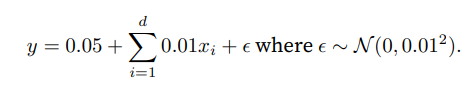  
选择标签是关于输⼊的线性函数。标签同时被均值为0，标准差为0.01⾼斯噪声破坏。为了使过拟合的效果更加明显，我们可以将问题的维数增加到d = 200，并使⽤⼀个只包含20个样本的⼩训练集。


In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)


## 初始化模型参数
从头开始实现权重衰减，只需将L2的平⽅惩罚添加到原始⽬标函数中。  
⾸先，我们将定义⼀个函数来随机初始化模型参数：

In [6]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义L2范数惩罚
实现这⼀惩罚最⽅便的⽅法是对所有项求平⽅后并将它们求和。

In [3]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### 定义训练代码实现
将模型拟合训练数据集，并在测试数据集上进⾏评估。线性⽹络和平⽅损失没有变化，所以我们通过d2l.linreg和d2l.squared_loss导⼊它们。唯⼀的变化是损失现在包括了惩罚项。


In [4]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # ⼴播机制使l2_penalty(w)成为⼀个⻓度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### 忽略正则化直接训练
现在⽤lambd = 0禁⽤权重衰减后运⾏这个代码。注意，这⾥训练误差有了减少，但测试误差没有减少，这意味着出现了严重的过拟合。

w的L2范数是： 14.83599853515625


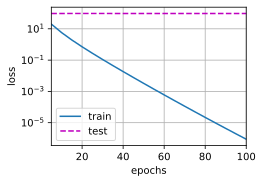

In [7]:
train(lambd=0)

### 使用权重衰减
使⽤权重衰减来运⾏代码。注意，在这⾥训练误差增⼤，但测试误差减⼩。这正是我们期望从正则化中得到的效果。

w的L2范数是： 0.36758410930633545


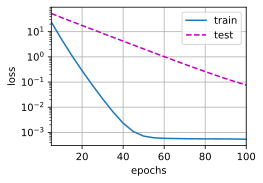

In [8]:
train(lambd=3)

## 简洁实现
由于权重衰减在神经⽹络优化中很常⽤，深度学习框架为了便于我们使⽤权重衰减，将权重衰减集成到优化算法中，以便与任何损失函数结合使⽤。此外，这种集成还有计算上的好处，允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。由于更新的权重衰减部分仅依赖于每个参数的当前值，因此优化器必须⾄少接触每个参数⼀次。  
在下⾯的代码中，我们在实例化优化器时直接通过weight_decay指定weight decay超参数。默认情况下，PyTorch同时衰减权重和偏移。这⾥我们只为权重设置了weight_decay，所以偏置参数b不会衰减。


In [9]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003

    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())


w的L2范数： 11.966042518615723


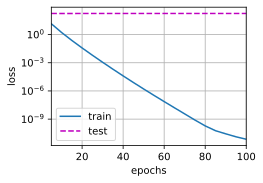

In [10]:
train_concise(0)


w的L2范数： 0.37605276703834534


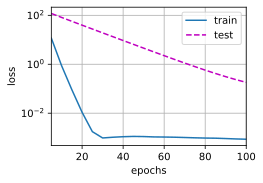

In [11]:
train_concise(3)


## 小结
* 正则化是处理过拟合的常⽤⽅法：在训练集的损失函数中加⼊惩罚项，以降低学习到的模型的复杂度。
* 保持模型简单的⼀个特别的选择是使⽤L2惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。
* 权重衰减功能在深度学习框架的优化器中提供。
* 在同⼀训练代码实现中，不同的参数集可以有不同的更新⾏为。